# Grad-CAM for Image Segmentation: Demo

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
from tqdm import tqdm

from interpretdl import Interpreter

from interpretdl.data_processor.readers import images_transform_pipeline, preprocess_save_path
from interpretdl.data_processor.visualizer import explanation_to_vis, show_vis_explanation, save_image


class GradCAMSegInterpreter(Interpreter):
    """This is one of the sub-abstract Interpreters. 
    
    :class:`InputGradientInterpreter` are used by input gradient based Interpreters. Interpreters that are derived from 
    :class:`InputGradientInterpreter` include :class:`GradShapCVInterpreter`, :class:`IntGradCVInterpreter`, 
    :class:`SmoothGradInterpreter`.

    This Interpreter implements :py:func:`_build_predict_fn` that returns input gradient given an input. 
    """

    def __init__(self, model: callable, device: str, **kwargs):
        """
        
        Args:
            model (callable): A model with :py:func:`forward` and possibly :py:func:`backward` functions.
            device (str): The device used for running ``model``, options: ``"cpu"``, ``"gpu:0"``, ``"gpu:1"`` 
                etc.
        """
        Interpreter.__init__(self, model, device)

        # init for usages during the interpretation.
        self._target_layer_name = None
        self._feature_maps = {}

    def _build_predict_fn(self, rebuild: bool = False, gradient_of: str = 'probability'):
        """Build ``predict_fn`` for input gradients based algorithms.
        The model is supposed to be a classification model.

        Args:
            rebuild (bool, optional): forces to rebuild. Defaults to ``False``.
            gradient_of (str, optional): computes the gradient of 
                [``"loss"``, ``"logit"`` or ``"probability"``] *w.r.t.* input data. Defaults to ``"probability"``. 
                Other options can get similar results while the absolute scale might be different.
        """

        if self.predict_fn is not None:
            assert callable(self.predict_fn), "predict_fn is predefined before, but is not callable." \
                "Check it again."

        if self.predict_fn is None or rebuild:
            assert gradient_of in ['loss', 'logit', 'probability']

            self._env_setup()

            def predict_fn(inputs, pixels, labels=None):
                """predict_fn for input gradients based interpreters,
                    for image classification models only.

                Args:
                    inputs ([type]): scaled inputs.
                    labels ([type]): can be None.

                Returns:
                    [type]: gradients, labels
                """
                import paddle
                # assert len(data.shape) == 4  # [bs, h, w, 3]
                assert labels is None or \
                    (isinstance(labels, (list, np.ndarray)) and len(labels) == inputs.shape[0])
                
                def hook(layer, input, output):
                    self._feature_maps[layer._layer_name_for_hook] = output
                    
                for n, v in self.model.named_sublayers():
                    if n == self._target_layer_name:
                        v._layer_name_for_hook = n
                        v.register_forward_post_hook(hook)
                    if "batchnorm" in v.__class__.__name__.lower():
                        v._use_global_stats = True
                    if "dropout" in v.__class__.__name__.lower():
                        v.p = 0
                    # Report issues or pull requests if more layers need to be added.
                    
                if isinstance(inputs, tuple):
                    tensor_inputs = []
                    for inp in inputs:
                        tmp = paddle.to_tensor(inp)
                        tmp.stop_gradient = False
                        tensor_inputs.append(tmp)
                    tensor_inputs = tuple(tensor_inputs)
                else:
                    tensor_inputs = paddle.to_tensor(inputs)
                    tensor_inputs.stop_gradient = False
                    tensor_inputs = (tensor_inputs, )

                # get logits and probas, [bs, num_c, H, W]
                logits_seg = self.model(*tensor_inputs)
                logits = logits_seg[0]
                num_samples, num_classes = logits.shape[0], logits.shape[1]
                probas = paddle.nn.functional.softmax(logits, axis=1)
                
                # aggregate pixels
                mask = paddle.zeros_like(logits, dtype=paddle.bool)
                mask.stop_gradient = True
                for i, j in pixels:
                    mask[:, :, i, j] = 1
                
                logits = (logits * mask).sum(axis=(-2, -1)) / len(pixels)
                probas = (probas * mask).sum(axis=(-2, -1)) / len(pixels)

                # get predictions.
                pred = paddle.argmax(logits, axis=1)
                if labels is None:
                    labels = pred.numpy()
                
                # get gradients
                if gradient_of == 'loss':
                    # cross-entropy loss
                    loss = paddle.nn.functional.cross_entropy(logits, paddle.to_tensor(labels), reduction='sum')
                else:
                    # logits or probas
                    labels = np.array(labels).reshape((num_samples, ))
                    labels_onehot = paddle.nn.functional.one_hot(paddle.to_tensor(labels), num_classes=num_classes)
                    # print('labels_onehot:', labels_onehot)
                    if gradient_of == 'logit':
                        loss = paddle.sum(logits * labels_onehot, axis=1)
                    else:
                        loss = paddle.sum(probas * labels_onehot, axis=1)
                
                # paddle gradient computation changes since 2.4
                paddle_version=tuple(map(int, paddle.__version__.split(".")))
                if paddle_version>=(2,4,0):
                    loss.backward(retain_graph=True) #since paddle 2.4
                    gradients = paddle.grad(
                        outputs=[loss], inputs=[self._feature_maps[self._target_layer_name]])[0]
                else:
                    loss.backward()
                    gradients = self._feature_maps[self._target_layer_name].grad
                    
                if isinstance(gradients, paddle.Tensor):
                    gradients = gradients.numpy()
                    
                loss.clear_gradient()
                return self._feature_maps[self._target_layer_name], gradients, labels

            self.predict_fn = predict_fn
            
    def interpret(self,
                  inputs: str or list(str) or np.ndarray,
                  pixels,  # h-axis, w-axis
                  labels: list or np.ndarray = None,
                  target_layer_name: str = None,
                  gradient_of: str = 'probability',
                  resize_to: int = 224,
                  crop_to: int = None,
                  visual: bool = True,
                  save_path: str = None) -> np.ndarray:
        """The technical details of the SmoothGrad method are described as follows:
        SmoothGrad generates ``n_samples`` noised inputs, with the noise scale of ``noise_amount``, and then computes 
        the gradients *w.r.t.* these noised inputs. The final explanation is averaged gradients.

        Args:
            inputs (str or list): The input image filepath or a list of filepaths or numpy array of read images.
            labels (list or np.ndarray, optional): The target labels to analyze. The number of labels should be equal 
                to the number of images. If None, the most likely label for each image will be used. Default: None.
            noise_amount (int, optional): Noise level of added noise to the image. The std of Gaussian random noise 
                is ``noise_amount`` * (x :sub:`max` - x :sub:`min`). Default: ``0.1``.
            n_samples (int, optional): The number of new images generated by adding noise. Default: ``50``.
            gradient_of (str, optional): compute the gradient of ['probability', 'logit' or 'loss']. Default: 
                ``'probability'``. SmoothGrad uses probability for all tasks by default.
            resize_to (int, optional): Images will be rescaled with the shorter edge being ``resize_to``. Defaults to 
                ``224``.
            crop_to (int, optional): After resize, images will be center cropped to a square image with the size 
                ``crop_to``. If None, no crop will be performed. Defaults to ``None``.
            visual (bool, optional): Whether or not to visualize the processed image. Default: ``True``.
            save_path (str, optional): The filepath(s) to save the processed image(s). If None, the image will not be 
                saved. Default: ``None``.

        Returns:
            np.ndarray: the explanation result.
        """
        self._target_layer_name = target_layer_name

        imgs, data = images_transform_pipeline(inputs, resize_to, crop_to)
        bsz = len(data)
        self._build_predict_fn(gradient_of=gradient_of)

        # obtain the labels (and initialization).
        feature_map, gradients, predicted_labels = self.predict_fn(data, pixels, labels)
        if labels is None:
            labels = predicted_labels

        # GradCAM
        f = np.array(feature_map.numpy())
        g = gradients

        # the core algorithm
        cam_weights = np.mean(g, (2, 3), keepdims=True)
        heatmap = cam_weights * f
        heatmap = heatmap.mean(1)
        gradcam_explanation = np.maximum(heatmap, 0)

        # visualize and save image.
        if save_path is None and not visual:
            # no need to visualize or save explanation results.
            pass
        else:
            save_path = preprocess_save_path(save_path, bsz)
            for i in range(bsz):
                # print(imgs[i].shape, avg_gradients[i].shape)
                vis_explanation = explanation_to_vis(imgs[i],
                                                     gradcam_explanation[i],
                                                     style='overlay_heatmap')
                if visual:
                    show_vis_explanation(vis_explanation)
                if save_path[i] is not None:
                    save_image(save_path[i], vis_explanation)

        # intermediate results, for possible further usages.
        self.predicted_labels = predicted_labels

        return gradcam_explanation

In [3]:
from paddleseg.models import DeepLabV3P, ResNet50_vd

trained_model_path = 'https://bj.bcebos.com/paddleseg/dygraph/pascal_voc12/deeplabv3p_resnet50_os8_voc12aug_512x512_40k/model.pdparams'
backbone = ResNet50_vd(multi_grid=(1,2,4))
m = DeepLabV3P(num_classes=21,
               backbone=backbone, 
               pretrained=trained_model_path)

m.eval()

W0313 16:48:47.780452 14971 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0313 16:48:47.784333 14971 gpu_resources.cc:91] device: 0, cuDNN Version: 8.1.


2023-03-13 16:48:49 [INFO]	No pretrained model to load, ResNet_vd will be trained from scratch.
2023-03-13 16:48:49 [INFO]	Loading pretrained model from https://bj.bcebos.com/paddleseg/dygraph/pascal_voc12/deeplabv3p_resnet50_os8_voc12aug_512x512_40k/model.pdparams
2023-03-13 16:48:50 [INFO]	There are 360/360 variables loaded into DeepLabV3P.


In [4]:
[n for n,l in m.named_sublayers()]

['backbone',
 'backbone.conv1_1',
 'backbone.conv1_1._pool2d_avg',
 'backbone.conv1_1._conv',
 'backbone.conv1_1._batch_norm',
 'backbone.conv1_1._act_op',
 'backbone.conv1_1._act_op.act_func',
 'backbone.conv1_2',
 'backbone.conv1_2._pool2d_avg',
 'backbone.conv1_2._conv',
 'backbone.conv1_2._batch_norm',
 'backbone.conv1_2._act_op',
 'backbone.conv1_2._act_op.act_func',
 'backbone.conv1_3',
 'backbone.conv1_3._pool2d_avg',
 'backbone.conv1_3._conv',
 'backbone.conv1_3._batch_norm',
 'backbone.conv1_3._act_op',
 'backbone.conv1_3._act_op.act_func',
 'backbone.pool2d_max',
 'backbone.bb_0_0',
 'backbone.bb_0_0.conv0',
 'backbone.bb_0_0.conv0._pool2d_avg',
 'backbone.bb_0_0.conv0._conv',
 'backbone.bb_0_0.conv0._batch_norm',
 'backbone.bb_0_0.conv0._act_op',
 'backbone.bb_0_0.conv0._act_op.act_func',
 'backbone.bb_0_0.conv1',
 'backbone.bb_0_0.conv1._pool2d_avg',
 'backbone.bb_0_0.conv1._conv',
 'backbone.bb_0_0.conv1._batch_norm',
 'backbone.bb_0_0.conv1._act_op',
 'backbone.bb_0_0.con

In [4]:
import numpy as np
import paddle
paddle.set_device('gpu:0')

from interpretdl.data_processor.readers import read_image, images_transform_pipeline

img_path = 'assets/catdog.png'

uint8_img, float_input_data = images_transform_pipeline(img_path, resize_to=512, crop_to=512)
input_data = paddle.to_tensor(float_input_data)
r = m(input_data)

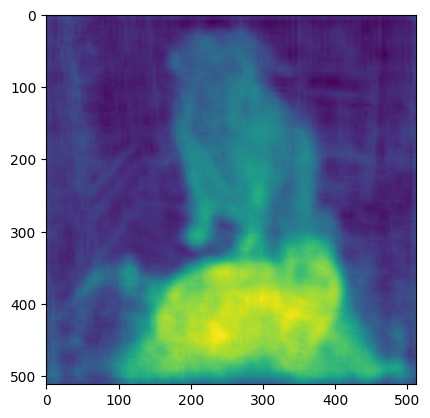

In [5]:
import matplotlib.pyplot as plt

c = r[0][0, 8].numpy()  # cat
# c = r[0][0, 12].numpy()  # dog

plt.imshow(c)

/opt/conda/envs/pp2/lib/python3.9/site-packages/paddle/fluid/dygraph/math_op_patch.py:276: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.bool, the right dtype will convert to paddle.float32
  warnings.warn(
/opt/conda/envs/pp2/lib/python3.9/site-packages/paddle/fluid/dygraph/varbase_patch_methods.py:523: UserWarning: 
tensor.grad will return the tensor value of the gradient. This is an incompatible upgrade for tensor.grad API.  It's return type changes from numpy.ndarray in version 2.0 to paddle.Tensor in version 2.1.0.  If you want to get the numpy value of the gradient, you can use :code:`x.grad.numpy()` 
  warnings.warn(warning_msg)


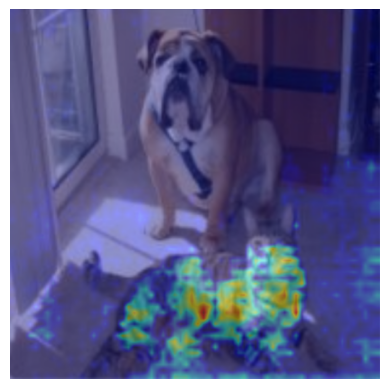

In [6]:
import interpretdl as it
gradcam = GradCAMSegInterpreter(m, 'gpu:0')

pixels = [(400, 200)]
# good layers for deeplabv3p: backbone.bb_3_2.relu, head.aspp, head.decoder.conv
exp = gradcam.interpret(img_path, pixels, target_layer_name='backbone.bb_3_2.relu', resize_to=512, crop_to=512)

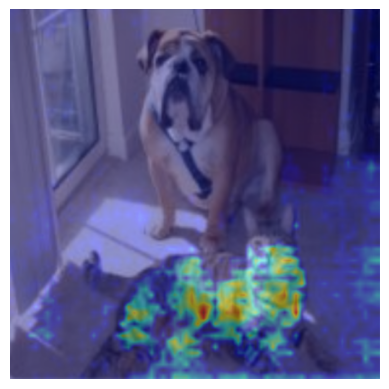

In [7]:
import interpretdl as it
gradcam = GradCAMSegInterpreter(m, 'gpu:0')

pixels = [(400, 200), (401, 200)]
exp = gradcam.interpret(img_path, pixels, target_layer_name='backbone.bb_3_2.relu', resize_to=512, crop_to=512)

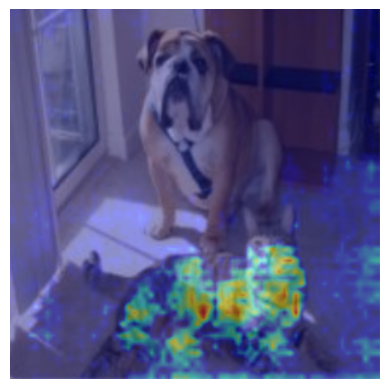

In [8]:
import interpretdl as it
gradcam = GradCAMSegInterpreter(m, 'gpu:0')

pixels = []
for i in range(400, 450, 1):
    for j in range(200, 300, 1):
        pixels.append((i, j))
exp = gradcam.interpret(img_path, pixels, target_layer_name='backbone.bb_3_2.relu', resize_to=512, crop_to=512)